In [1]:


#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")

Mounted at /content/MyDrive


In [2]:
import os
import torch
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.io import wavfile
from sklearn.metrics import mean_squared_error
import statistics
from scipy.signal import savgol_filter, butter, filtfilt

class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 64)
        self.epochs = kwargs.get('epochs', 50)
        self.lr = kwargs.get('lr', 0.001)
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

In [3]:
class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)

        self.scaler_save_path = os.path.join(self.config.dataset_root, dataset_name, "scaler.pkl")
        self.scaler = joblib.load(self.scaler_save_path) if os.path.exists(self.scaler_save_path) else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])

        if self.input_format == "wav":
            combined_data, _ = get_data_from_wav_file(file_path)
        elif self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


In [4]:
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim,print_losses=True):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]

  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no


  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]



  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  Z_1=y_1
  Z_2=y_2
  Z_3=y_3



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))





  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]




              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)


  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)


  if print_losses:
    print(rmse_1)
    print(rmse_2)
    print(rmse_3)
    print("\n")
    print(p_1)
    print(p_2)
    print(p_3)
    print('Mean: %.3f' % m,'+/- %.3f' %SD)
    print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)

  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss




In [6]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import time
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from scipy.signal import butter, filtfilt
import statistics

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, filename, train_loss, val_loss, test_loss=None, channelwise_metrics=None):
    """Saves the model, optimizer state, and losses (including channel-wise) to a checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_channelwise_metrics': channelwise_metrics['train'],
        'val_channelwise_metrics': channelwise_metrics['val'],
    }
    if test_loss is not None:
        checkpoint['test_loss'] = test_loss
        checkpoint['test_channelwise_metrics'] = channelwise_metrics['test']



    torch.save(checkpoint, filename)
    print(f"Checkpoint saved for epoch {epoch + 1}")

# Evaluation function
def evaluate_model(device, model, loader, criterion):
    """Runs evaluation on the validation or test set."""
    model.eval()
    total_loss = 0.0
    total_pcc = np.zeros(len(config.channels_joints))
    total_rmse = np.zeros(len(config.channels_joints))

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            total_loss += loss.item()
            total_pcc += batch_pcc
            total_rmse += batch_rmse

    avg_loss = total_loss / len(loader)
    avg_pcc = total_pcc / len(loader)
    avg_rmse = total_rmse / len(loader)

    return avg_loss, avg_pcc, avg_rmse

# Training function
def train_teacher(device, train_loader, val_loader, test_loader, learn_rate, epochs, model, filename):
    if torch.cuda.is_available():
        model.cuda()

    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        epoch_train_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_train_rmse = np.zeros(len(config.channels_joints))

        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")):
            optimizer.zero_grad()
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()

            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            epoch_train_loss += loss.detach().cpu().numpy()
            epoch_train_pcc += batch_pcc
            epoch_train_rmse += batch_rmse

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_pcc = epoch_train_pcc / len(train_loader)
        avg_train_rmse = epoch_train_rmse / len(train_loader)

        train_losses.append(avg_train_loss)
        train_pccs.append(avg_train_pcc)
        train_rmses.append(avg_train_rmse)

        # Evaluate on validation set every epoch
        avg_val_loss, avg_val_pcc, avg_val_rmse = evaluate_model(device, model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_pccs.append(avg_val_pcc)
        val_rmses.append(avg_val_rmse)


        # Evaluate on test set and checkpoint every epoch
        avg_test_loss, avg_test_pcc, avg_test_rmse = evaluate_model(device, model, test_loader, criterion)
        test_losses.append(avg_test_loss)
        test_pccs.append(avg_test_pcc)
        test_rmses.append(avg_test_rmse)

        print(f"Epoch: {epoch + 1}, Training Loss: {np.mean(avg_train_loss)}, Validation Loss: {np.mean(avg_val_loss):.4f}", f"Test Loss: {np.mean(avg_test_loss):.4f}")
        print(f"Training PCC: {np.mean(avg_train_pcc)}, Validation PCC: {np.mean(avg_val_pcc):.4f}", f"Test PCC: {np.mean(avg_test_pcc):.4f}")


        if not os.path.exists(f"/content/MyDrive/MyDrive/models/{filename}"):
          os.makedirs(f"/content/MyDrive/MyDrive/models/{filename}")

        # Save checkpoint, including channel-wise metrics
        save_checkpoint(
            model,
            optimizer,
            epoch,
            f"/content/MyDrive/MyDrive/models/{filename}/{filename}_epoch_{epoch+1}.pth",
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            test_loss=avg_test_loss,
            channelwise_metrics={
                'train': {'pcc': avg_train_pcc, 'rmse': avg_train_rmse},
                'val': {'pcc': avg_val_pcc, 'rmse': avg_val_rmse},
                'test': {'pcc': avg_test_pcc, 'rmse': avg_test_rmse},
            }
        )

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses


In [7]:
class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'wav':
            self._process_and_save_patients_wav(self.config.train_subjects, "train")
            self._process_and_save_patients_wav(self.config.test_subjects, "test")
        elif self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _process_and_save_patients_wav(self, patient_id_list, split):
        total_data = []
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            for session_index in tqdm(range(len(self.config.train_subjects)), desc=f"Processing sessions for {patient_id}", leave=False):
                imu_data, imu_sample_rate = self._load_wav_file(patient_id, session_index, "IMU")
                joints_data, joints_sample_rate = self._load_wav_file(patient_id, session_index, "JOINTS")
                emg_data, emg_sample_rate = self._load_wav_file(patient_id, session_index, "EMG")

                imu_data = self._resample_data(imu_data, imu_sample_rate)
                joints_data = self._resample_data(joints_data, joints_sample_rate)
                emg_data = self._resample_data(emg_data, emg_sample_rate)

                combined_data = torch.cat((imu_data, joints_data, emg_data), dim=1)
                total_data.append(combined_data.cpu().numpy())

        if self.save_h5:
            self._save_to_h5(total_data, split)
        else:
            for combined_data in total_data:
                self._save_windowed_data(combined_data, patient_id, session_index, split)

    def _load_wav_file(self, patient_id, session_index, file_type):
        file_path = os.path.join(self.data_folder_path, patient_id, f"run{session_index}_{file_type}.wav")
        data, sample_rate = get_data_from_wav_file(file_path)
        return torch.tensor(data, dtype=torch.float32), sample_rate

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))


In [8]:
import shutil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection',
    dataset_root='/content/datasets',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=150,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_2','subject_3','subject_4','subject_6','subject_7','subject_8', 'subject_9','subject_10', 'subject_11','subject_12','subject_13'],
    test_subjects=['subject_1']
)





In [9]:
reshard = True

if reshard:
  data_sharder = DataSharder(config)
  data_sharder.load_data()

  #copy new dataset to drive
  # shutil.copytree(os.path.join("/content/datasets",config.dataset_name),os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name))

if not os.path.exists("/content/datasets"):
    #copy over
    shutil.copytree(os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name),os.path.join("/content/datasets",config.dataset_name))



Training subjects: ['subject_2', 'subject_3', 'subject_4', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13']
Testing subjects: ['subject_1']


Processing train patients:   0%|          | 0/11 [00:00<?, ?it/s]

Processing sessions for subject_2:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_90_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_45_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_3:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreach45_combined:   0%|          | 0/126 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreach90_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_slow_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T002_elbowrotation_slow_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowrotation_fast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_normal_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_veryfast_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_fast_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowrotation_normal_combined:   0%|          | 0/78 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T003_armswing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_fast_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreachMax_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_slow_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Processing sessions for subject_4:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowrotation_slow_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_crossbody_slow_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_crossbody_fast_combined:   0%|          | 0/142 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowrotation_fast_combined:   0%|          | 0/140 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_crossbody_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowrotation_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowflexion_fast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowflexion_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_6:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_slow_combined:   0%|          | 0/112 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_overheadreach_45_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowflexion_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowrotation_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_7:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T002_armSwing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowflexion_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowrotation_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowrotation_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_overheadreach_45_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_armSwing_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_armSwing_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_8:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowflexion_fast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_fast_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_crossbody_fast_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowrotation_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowflexion_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_9:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_normal_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_elbowflexion_normal_combined:   0%|          | 0/127 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_veryfast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_elbowflexion_slow_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_overheadreach_max_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowrotation_fast_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_overheadreach_45_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_crossbody_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowrotation_slow_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowrotation_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_crossbody_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Processing sessions for subject_10:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T002_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T002_elbowrotation_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_crossbody_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_crossbody_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T002_elbowrotation_normal_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Processing sessions for subject_11:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_overheadreach_90_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_overheadreach_max_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_crossbody_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowflexion_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Processing sessions for subject_12:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowrotation_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s…

Windowing data for subject_12_P0012_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_slow_combined:   0%|          | 0/126 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowflexion_slow_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowrotation_fast_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowflexion_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_crossbody_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowflexion_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_crossbody_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Processing sessions for subject_13:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_veryfast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowrotation_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_slow_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_crossbody_fast_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowflexion_fast_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_overheadreach_45_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowrotation_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowflexion_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Processing test patients:   0%|          | 0/1 [00:00<?, ?it/s]

Processing sessions for subject_1:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_crossbody_fast_combined:   0%|          | 0/130 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowrotation_fast_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowflexion_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_fast_combined:   0%|          | 0/126 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_veryfast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_overheadreach_max_combined:   0%|          | 0/130 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowflexion_slow_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_overheadreach_90_combined:   0%|          | 0/130 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_slow_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowrotation_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowrotation_slow_combined:   0%|          | 0/131 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_overheadreach_45_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowflexion_normal_combined:   0%|          | 0/127 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_crossbody_normal_combined:   0%|          | 0/131 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_crossbody_slow_combined:   0%|          | 0/129 [00:00<?, ?it/s]

In [10]:
# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# Train the model
model = teacher(
    input_acc=len(config.channels_imu_acc),
    input_gyr=len(config.channels_imu_gyr),
    input_emg=len(config.channels_emg)
)

In [11]:

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

print(acc.dtype)
print(gyro.dtype)
print(target.dtype)
print(emg.dtype)


torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])
torch.float32
torch.float32
torch.float32
torch.float32


In [12]:
model = teacher(18, 18, 3,drop_prob=.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


#train teacher
model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses = train_teacher(device,train_loader, val_loader, test_loader,config.lr, config.epochs, model, 'new_opensimmodel_first_run_no_subject_5_RMSE_higherdropout')

Epoch 1/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 21.0869655481549, Validation Loss: 13.0403 Test Loss: 22.3503
Training PCC: 0.7541374342066515, Validation PCC: 0.9269 Test PCC: 0.5556
Checkpoint saved for epoch 1


Epoch 2/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 11.774095701134721, Validation Loss: 10.9443 Test Loss: 20.8069
Training PCC: 0.9426522824978831, Validation PCC: 0.9577 Test PCC: 0.5540
Checkpoint saved for epoch 2


Epoch 3/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 10.179508620679977, Validation Loss: 9.7103 Test Loss: 18.9029
Training PCC: 0.9593811276366558, Validation PCC: 0.9654 Test PCC: 0.6020
Checkpoint saved for epoch 3


Epoch 4/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 9.479226185725285, Validation Loss: 8.4401 Test Loss: 18.1658
Training PCC: 0.9644860614838041, Validation PCC: 0.9707 Test PCC: 0.6129
Checkpoint saved for epoch 4


Epoch 5/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 8.827397257189288, Validation Loss: 8.1343 Test Loss: 18.4541
Training PCC: 0.9688409540215543, Validation PCC: 0.9749 Test PCC: 0.6074
Checkpoint saved for epoch 5


Epoch 6/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 8.524512704000824, Validation Loss: 7.4654 Test Loss: 17.6394
Training PCC: 0.9712087486831137, Validation PCC: 0.9771 Test PCC: 0.6187
Checkpoint saved for epoch 6


Epoch 7/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 8.154740095935937, Validation Loss: 7.8184 Test Loss: 19.0297
Training PCC: 0.9737243065502114, Validation PCC: 0.9756 Test PCC: 0.6052
Checkpoint saved for epoch 7


Epoch 8/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 7.86755865792367, Validation Loss: 7.1666 Test Loss: 18.8189
Training PCC: 0.9750721531329601, Validation PCC: 0.9796 Test PCC: 0.6330
Checkpoint saved for epoch 8


Epoch 9/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 7.637796540722799, Validation Loss: 6.8713 Test Loss: 17.4053
Training PCC: 0.9767213863785654, Validation PCC: 0.9809 Test PCC: 0.6607
Checkpoint saved for epoch 9


Epoch 10/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 7.340512264532389, Validation Loss: 6.5872 Test Loss: 17.1453
Training PCC: 0.9783895478190278, Validation PCC: 0.9812 Test PCC: 0.6588
Checkpoint saved for epoch 10


Epoch 11/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 7.100924444039131, Validation Loss: 6.7585 Test Loss: 17.2548
Training PCC: 0.9798053895236709, Validation PCC: 0.9819 Test PCC: 0.6562
Checkpoint saved for epoch 11


Epoch 12/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 6.996017275845326, Validation Loss: 6.3159 Test Loss: 18.5874
Training PCC: 0.9805141253860031, Validation PCC: 0.9836 Test PCC: 0.6205
Checkpoint saved for epoch 12


Epoch 13/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 6.891758618944864, Validation Loss: 6.6349 Test Loss: 17.6158
Training PCC: 0.9803921990638259, Validation PCC: 0.9825 Test PCC: 0.6334
Checkpoint saved for epoch 13


Epoch 14/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 6.567205566227636, Validation Loss: 6.0575 Test Loss: 17.4323
Training PCC: 0.9822758606711779, Validation PCC: 0.9850 Test PCC: 0.6516
Checkpoint saved for epoch 14


Epoch 15/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 6.199172987985771, Validation Loss: 6.5416 Test Loss: 17.9316
Training PCC: 0.9844472249618992, Validation PCC: 0.9837 Test PCC: 0.6414
Checkpoint saved for epoch 15


Epoch 16/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 6.16206914046935, Validation Loss: 6.7977 Test Loss: 17.5789
Training PCC: 0.9843809767005586, Validation PCC: 0.9799 Test PCC: 0.6732
Checkpoint saved for epoch 16


Epoch 17/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 6.464177171522159, Validation Loss: 6.5013 Test Loss: 17.3809
Training PCC: 0.9825115138481465, Validation PCC: 0.9849 Test PCC: 0.6523
Checkpoint saved for epoch 17


Epoch 18/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 5.958659205548341, Validation Loss: 5.9414 Test Loss: 17.5769
Training PCC: 0.9854568541951151, Validation PCC: 0.9853 Test PCC: 0.6853
Checkpoint saved for epoch 18


Epoch 19/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 5.784693961956829, Validation Loss: 5.5610 Test Loss: 17.4365
Training PCC: 0.9864413229509253, Validation PCC: 0.9875 Test PCC: 0.6911
Checkpoint saved for epoch 19


Epoch 20/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 5.762397137772678, Validation Loss: 5.5931 Test Loss: 17.3539
Training PCC: 0.9867402926909477, Validation PCC: 0.9872 Test PCC: 0.6906
Checkpoint saved for epoch 20


Epoch 21/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 5.6868903644906235, Validation Loss: 5.5237 Test Loss: 16.9936
Training PCC: 0.9870647723110952, Validation PCC: 0.9872 Test PCC: 0.6686
Checkpoint saved for epoch 21


Epoch 22/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 5.5442028404478245, Validation Loss: 5.6710 Test Loss: 17.5305
Training PCC: 0.9874239942699807, Validation PCC: 0.9870 Test PCC: 0.6948
Checkpoint saved for epoch 22


Epoch 23/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 5.4708078346124855, Validation Loss: 6.0728 Test Loss: 17.5902
Training PCC: 0.9878191870994485, Validation PCC: 0.9869 Test PCC: 0.6911
Checkpoint saved for epoch 23


Epoch 24/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 5.449577294863187, Validation Loss: 5.4029 Test Loss: 17.3557
Training PCC: 0.9878359287384847, Validation PCC: 0.9877 Test PCC: 0.6752
Checkpoint saved for epoch 24


Epoch 25/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 5.364837845033627, Validation Loss: 5.6371 Test Loss: 16.5468
Training PCC: 0.9881762670366151, Validation PCC: 0.9875 Test PCC: 0.7156
Checkpoint saved for epoch 25


Epoch 26/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 5.191004735570289, Validation Loss: 5.3532 Test Loss: 16.7813
Training PCC: 0.9888589994820073, Validation PCC: 0.9878 Test PCC: 0.7018
Checkpoint saved for epoch 26


Epoch 27/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 5.083176588932408, Validation Loss: 5.3975 Test Loss: 16.9630
Training PCC: 0.9892420223382733, Validation PCC: 0.9882 Test PCC: 0.7033
Checkpoint saved for epoch 27


Epoch 28/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 5.031894114503892, Validation Loss: 5.4672 Test Loss: 17.1498
Training PCC: 0.989390964595542, Validation PCC: 0.9886 Test PCC: 0.6724
Checkpoint saved for epoch 28


Epoch 29/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 5.128957013222685, Validation Loss: 5.6912 Test Loss: 17.2856
Training PCC: 0.9891250651120935, Validation PCC: 0.9879 Test PCC: 0.7128
Checkpoint saved for epoch 29


Epoch 30/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 5.060144206751948, Validation Loss: 5.5027 Test Loss: 17.3956
Training PCC: 0.9894010389438783, Validation PCC: 0.9880 Test PCC: 0.6839
Checkpoint saved for epoch 30


Epoch 31/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 5.220276155599383, Validation Loss: 5.4308 Test Loss: 17.6254
Training PCC: 0.9886400943541527, Validation PCC: 0.9871 Test PCC: 0.6496
Checkpoint saved for epoch 31


Epoch 32/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 5.549165000883632, Validation Loss: 5.6399 Test Loss: 17.2130
Training PCC: 0.9872824809116815, Validation PCC: 0.9874 Test PCC: 0.6746
Checkpoint saved for epoch 32


Epoch 33/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 5.168205632015216, Validation Loss: 5.3593 Test Loss: 17.3055
Training PCC: 0.9889346528469263, Validation PCC: 0.9888 Test PCC: 0.7129
Checkpoint saved for epoch 33


Epoch 34/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 4.889363069598093, Validation Loss: 5.6756 Test Loss: 18.2194
Training PCC: 0.9897109962690998, Validation PCC: 0.9888 Test PCC: 0.6741
Checkpoint saved for epoch 34


Epoch 35/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 4.712957918045912, Validation Loss: 5.6381 Test Loss: 18.0808
Training PCC: 0.9906185542104035, Validation PCC: 0.9872 Test PCC: 0.6974
Checkpoint saved for epoch 35


Epoch 36/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 4.992050747408915, Validation Loss: 4.9312 Test Loss: 17.4081
Training PCC: 0.9892062291030469, Validation PCC: 0.9898 Test PCC: 0.6875
Checkpoint saved for epoch 36


Epoch 37/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 4.66840260802304, Validation Loss: 4.9335 Test Loss: 17.4832
Training PCC: 0.9908191290638898, Validation PCC: 0.9897 Test PCC: 0.6715
Checkpoint saved for epoch 37


Epoch 38/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 4.466029057135949, Validation Loss: 5.5518 Test Loss: 17.3749
Training PCC: 0.9916636405388338, Validation PCC: 0.9895 Test PCC: 0.6621
Checkpoint saved for epoch 38


Epoch 39/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 4.4628121103331395, Validation Loss: 5.1406 Test Loss: 17.1122
Training PCC: 0.9916573452668067, Validation PCC: 0.9894 Test PCC: 0.6828
Checkpoint saved for epoch 39


Epoch 40/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 4.503764256984494, Validation Loss: 5.2826 Test Loss: 17.6386
Training PCC: 0.9914336764249619, Validation PCC: 0.9899 Test PCC: 0.6866
Checkpoint saved for epoch 40


Epoch 41/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 4.631310756389912, Validation Loss: 5.3670 Test Loss: 19.5440
Training PCC: 0.9913005152691778, Validation PCC: 0.9889 Test PCC: 0.6418
Checkpoint saved for epoch 41


Epoch 42/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 4.647007927049363, Validation Loss: 5.3403 Test Loss: 18.6553
Training PCC: 0.9910327586627375, Validation PCC: 0.9895 Test PCC: 0.6824
Checkpoint saved for epoch 42


Epoch 43/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 4.463950031178452, Validation Loss: 5.0688 Test Loss: 18.0863
Training PCC: 0.9915839945868639, Validation PCC: 0.9900 Test PCC: 0.6960
Checkpoint saved for epoch 43


Epoch 44/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 4.311209914676322, Validation Loss: 5.1790 Test Loss: 17.7845
Training PCC: 0.9921966041921461, Validation PCC: 0.9904 Test PCC: 0.6756
Checkpoint saved for epoch 44


Epoch 45/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 4.362045951511549, Validation Loss: 5.0279 Test Loss: 17.2932
Training PCC: 0.9917646108503425, Validation PCC: 0.9909 Test PCC: 0.6858
Checkpoint saved for epoch 45


Epoch 46/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 4.293116440342422, Validation Loss: 5.0676 Test Loss: 17.6332
Training PCC: 0.9921183823782521, Validation PCC: 0.9902 Test PCC: 0.6592
Checkpoint saved for epoch 46


Epoch 47/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 4.137096828441556, Validation Loss: 4.9398 Test Loss: 17.1773
Training PCC: 0.9927668842087572, Validation PCC: 0.9921 Test PCC: 0.6965
Checkpoint saved for epoch 47


Epoch 48/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 4.145733764737745, Validation Loss: 5.0759 Test Loss: 17.4672
Training PCC: 0.992856433345524, Validation PCC: 0.9914 Test PCC: 0.6990
Checkpoint saved for epoch 48


Epoch 49/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 4.1023113025869415, Validation Loss: 5.1845 Test Loss: 17.3907
Training PCC: 0.9929358653353312, Validation PCC: 0.9914 Test PCC: 0.6865
Checkpoint saved for epoch 49


Epoch 50/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 4.0657631114972475, Validation Loss: 4.9215 Test Loss: 16.4445
Training PCC: 0.9929750644156704, Validation PCC: 0.9909 Test PCC: 0.7024
Checkpoint saved for epoch 50


Epoch 51/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 4.10542940136581, Validation Loss: 5.1362 Test Loss: 17.1082
Training PCC: 0.9930102442115096, Validation PCC: 0.9914 Test PCC: 0.7030
Checkpoint saved for epoch 51


Epoch 52/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 4.104796458247513, Validation Loss: 4.9773 Test Loss: 17.9284
Training PCC: 0.9929583578774882, Validation PCC: 0.9915 Test PCC: 0.6780
Checkpoint saved for epoch 52


Epoch 53/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 4.017145447906443, Validation Loss: 4.9000 Test Loss: 17.4935
Training PCC: 0.9930320175947767, Validation PCC: 0.9917 Test PCC: 0.6863
Checkpoint saved for epoch 53


Epoch 54/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 4.362564486404725, Validation Loss: 5.0797 Test Loss: 17.0681
Training PCC: 0.9918547240672407, Validation PCC: 0.9910 Test PCC: 0.6805
Checkpoint saved for epoch 54


Epoch 55/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 4.437985838854991, Validation Loss: 5.4189 Test Loss: 17.0820
Training PCC: 0.9915421928167, Validation PCC: 0.9904 Test PCC: 0.6815
Checkpoint saved for epoch 55


Epoch 56/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 4.430120959329765, Validation Loss: 4.8253 Test Loss: 17.2449
Training PCC: 0.9914596018915237, Validation PCC: 0.9922 Test PCC: 0.7005
Checkpoint saved for epoch 56


Epoch 57/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 57, Training Loss: 4.065198285125171, Validation Loss: 5.0327 Test Loss: 16.3642
Training PCC: 0.9927207128464586, Validation PCC: 0.9921 Test PCC: 0.7079
Checkpoint saved for epoch 57


Epoch 58/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 58, Training Loss: 3.905239369159558, Validation Loss: 4.7342 Test Loss: 17.1631
Training PCC: 0.993493034859262, Validation PCC: 0.9932 Test PCC: 0.6900
Checkpoint saved for epoch 58


Epoch 59/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 59, Training Loss: 3.86053115946792, Validation Loss: 5.0314 Test Loss: 16.3452
Training PCC: 0.9937454731453714, Validation PCC: 0.9933 Test PCC: 0.7165
Checkpoint saved for epoch 59


Epoch 60/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 60, Training Loss: 3.9008879007703086, Validation Loss: 4.5084 Test Loss: 16.8937
Training PCC: 0.9935013366489573, Validation PCC: 0.9931 Test PCC: 0.6837
Checkpoint saved for epoch 60


Epoch 61/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 61, Training Loss: 3.823313815936596, Validation Loss: 4.7148 Test Loss: 16.8124
Training PCC: 0.9938306356977744, Validation PCC: 0.9934 Test PCC: 0.6864
Checkpoint saved for epoch 61


Epoch 62/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 62, Training Loss: 3.7984197211504784, Validation Loss: 4.6766 Test Loss: 16.3554
Training PCC: 0.9938912635039667, Validation PCC: 0.9929 Test PCC: 0.7050
Checkpoint saved for epoch 62


Epoch 63/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 63, Training Loss: 3.7482685652066237, Validation Loss: 4.3763 Test Loss: 16.8776
Training PCC: 0.9939754016829389, Validation PCC: 0.9934 Test PCC: 0.6917
Checkpoint saved for epoch 63


Epoch 64/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 64, Training Loss: 3.7256719460056775, Validation Loss: 4.8372 Test Loss: 17.4854
Training PCC: 0.993973785344746, Validation PCC: 0.9937 Test PCC: 0.6965
Checkpoint saved for epoch 64


Epoch 65/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 65, Training Loss: 3.923820808978384, Validation Loss: 5.0039 Test Loss: 17.4877
Training PCC: 0.993439411204558, Validation PCC: 0.9920 Test PCC: 0.6680
Checkpoint saved for epoch 65


Epoch 66/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 66, Training Loss: 4.18894773183459, Validation Loss: 5.0926 Test Loss: 17.0853
Training PCC: 0.9924212520923935, Validation PCC: 0.9916 Test PCC: 0.6801
Checkpoint saved for epoch 66


Epoch 67/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 67, Training Loss: 3.9790106999834247, Validation Loss: 5.0481 Test Loss: 16.8598
Training PCC: 0.9934115465327142, Validation PCC: 0.9924 Test PCC: 0.6905
Checkpoint saved for epoch 67


Epoch 68/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 68, Training Loss: 3.858617601586026, Validation Loss: 4.8979 Test Loss: 17.2259
Training PCC: 0.9937361761671833, Validation PCC: 0.9932 Test PCC: 0.6871
Checkpoint saved for epoch 68


Epoch 69/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 69, Training Loss: 3.68688976645071, Validation Loss: 4.6894 Test Loss: 17.7894
Training PCC: 0.994148096018332, Validation PCC: 0.9931 Test PCC: 0.6695
Checkpoint saved for epoch 69


Epoch 70/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 70, Training Loss: 3.6083543930564037, Validation Loss: 4.6994 Test Loss: 17.3197
Training PCC: 0.994464603246397, Validation PCC: 0.9922 Test PCC: 0.6732
Checkpoint saved for epoch 70


Epoch 71/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 71, Training Loss: 3.790991617285687, Validation Loss: 4.6637 Test Loss: 16.8983
Training PCC: 0.9938665592947298, Validation PCC: 0.9927 Test PCC: 0.6798
Checkpoint saved for epoch 71


Epoch 72/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 72, Training Loss: 3.698969188741218, Validation Loss: 4.8319 Test Loss: 17.3366
Training PCC: 0.9940907166978562, Validation PCC: 0.9937 Test PCC: 0.6704
Checkpoint saved for epoch 72


Epoch 73/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 73, Training Loss: 3.5697157933161807, Validation Loss: 5.0422 Test Loss: 17.1998
Training PCC: 0.9945175656992705, Validation PCC: 0.9932 Test PCC: 0.6822
Checkpoint saved for epoch 73


Epoch 74/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 74, Training Loss: 3.609722023424895, Validation Loss: 4.7563 Test Loss: 16.8224
Training PCC: 0.9943534740801844, Validation PCC: 0.9940 Test PCC: 0.6963
Checkpoint saved for epoch 74


Epoch 75/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 75, Training Loss: 3.5368945638471616, Validation Loss: 4.9196 Test Loss: 17.7626
Training PCC: 0.9947527273212433, Validation PCC: 0.9929 Test PCC: 0.6772
Checkpoint saved for epoch 75


Epoch 76/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 76, Training Loss: 3.6382927870670687, Validation Loss: 4.6388 Test Loss: 17.3078
Training PCC: 0.9943230507627652, Validation PCC: 0.9932 Test PCC: 0.7056
Checkpoint saved for epoch 76


Epoch 77/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 77, Training Loss: 3.5308994513291574, Validation Loss: 4.9795 Test Loss: 16.9262
Training PCC: 0.994517263171641, Validation PCC: 0.9934 Test PCC: 0.6957
Checkpoint saved for epoch 77


Epoch 78/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 78, Training Loss: 3.5556832149275963, Validation Loss: 4.9520 Test Loss: 17.2717
Training PCC: 0.9945942062560861, Validation PCC: 0.9928 Test PCC: 0.7021
Checkpoint saved for epoch 78


Epoch 79/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 79, Training Loss: 3.491359186013008, Validation Loss: 4.5127 Test Loss: 17.1346
Training PCC: 0.9946353282562866, Validation PCC: 0.9941 Test PCC: 0.6817
Checkpoint saved for epoch 79


Epoch 80/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 80, Training Loss: 3.549453498527756, Validation Loss: 4.5478 Test Loss: 17.2636
Training PCC: 0.994567899801968, Validation PCC: 0.9944 Test PCC: 0.6843
Checkpoint saved for epoch 80


Epoch 81/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 81, Training Loss: 3.52607528900223, Validation Loss: 4.8781 Test Loss: 17.1728
Training PCC: 0.9947075033184684, Validation PCC: 0.9945 Test PCC: 0.6918
Checkpoint saved for epoch 81


Epoch 82/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 82, Training Loss: 3.4647114189173465, Validation Loss: 4.7822 Test Loss: 17.0456
Training PCC: 0.9948348632579878, Validation PCC: 0.9937 Test PCC: 0.6869
Checkpoint saved for epoch 82


Epoch 83/150 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 83, Training Loss: 3.4292796479419727, Validation Loss: 4.9469 Test Loss: 16.4422
Training PCC: 0.9949595551074988, Validation PCC: 0.9937 Test PCC: 0.6999
Checkpoint saved for epoch 83
Stopping early after 83 epochs
Total training time: 15025.16 seconds


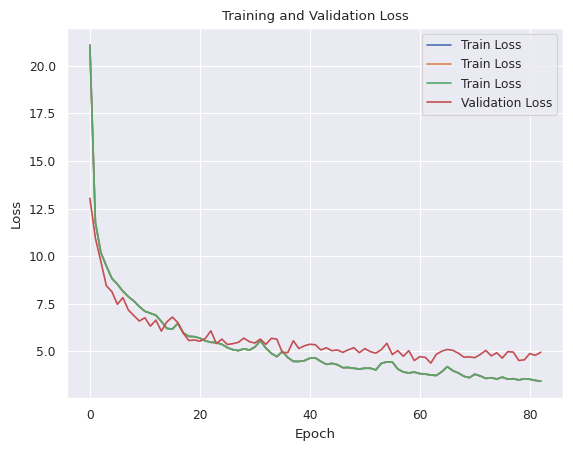

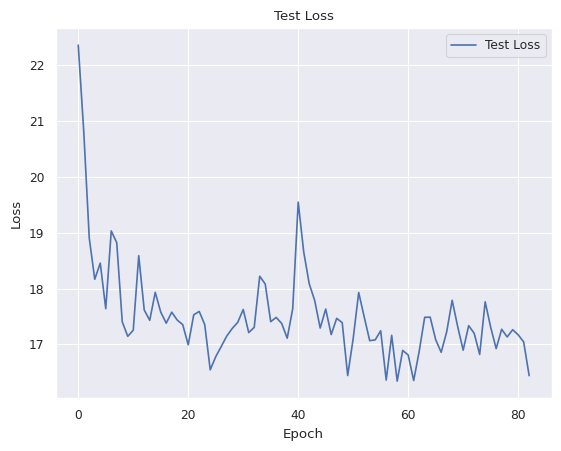

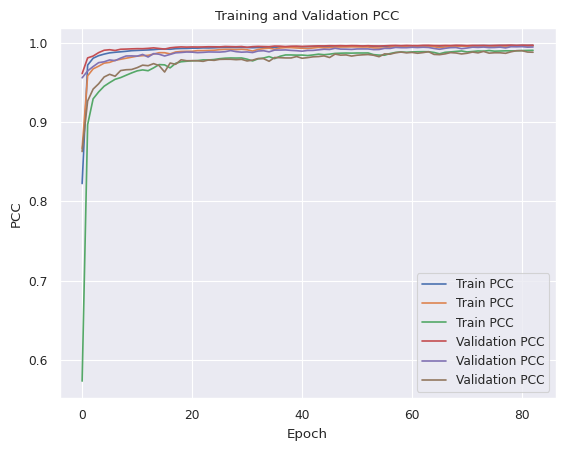

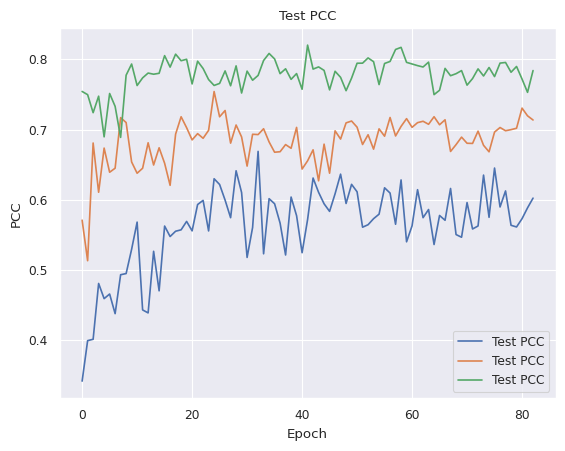

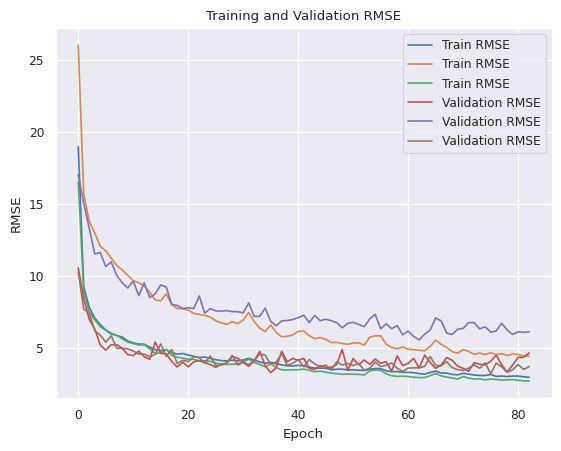

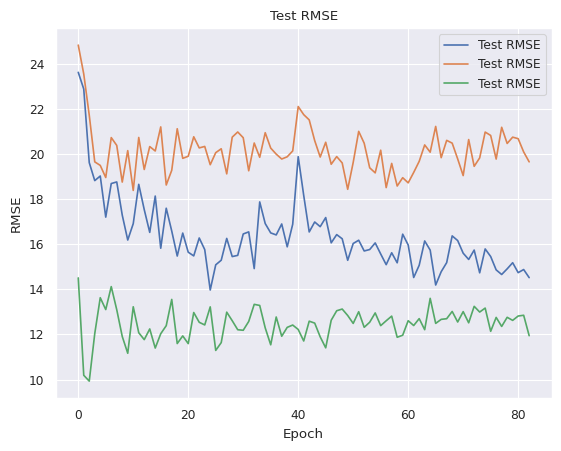

In [13]:
# prompt: plot necessary values

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()


plt.plot(train_pccs, label='Train PCC')
plt.plot(val_pccs, label='Validation PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.title('Training and Validation PCC')
plt.legend()
plt.show()

plt.plot(test_pccs, label='Test PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.title('Test PCC')
plt.legend()
plt.show()

plt.plot(train_rmses, label='Train RMSE')
plt.plot(val_rmses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

plt.plot(test_rmses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.legend()
plt.show()